# iLykei Lecture Series

# Machine Learning

# Introduction Workshop

***Yuri Balasanov, Victor Lavrentyev, Mihail Tselishchev, &copy; iLykei 2017***

## Linear Regression with Large Number of Predictors


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Linear-Regression-with-Large-Number-of-Predictors" data-toc-modified-id="Linear-Regression-with-Large-Number-of-Predictors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Linear Regression with Large Number of Predictors</a></span><ul class="toc-item"><li><span><a href="#Simulation-of-the-data" data-toc-modified-id="Simulation-of-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Simulation of the data</a></span></li><li><span><a href="#Analysis-of-accuracy-of-inference-as-function-of-number-of-predictors" data-toc-modified-id="Analysis-of-accuracy-of-inference-as-function-of-number-of-predictors-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Analysis of accuracy of inference as function of number of predictors</a></span></li><li><span><a href="#Selecting-predictors-for-regression-problem" data-toc-modified-id="Selecting-predictors-for-regression-problem-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Selecting predictors for regression problem</a></span><ul class="toc-item"><li><span><a href="#Method-based-on-drop1()" data-toc-modified-id="Method-based-on-drop1()-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Method based on <code>drop1()</code></a></span></li><li><span><a href="#Relative-importance-measures" data-toc-modified-id="Relative-importance-measures-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Relative importance measures</a></span></li><li><span><a href="#Regsubsets" data-toc-modified-id="Regsubsets-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Regsubsets</a></span></li></ul></li></ul></li></ul></div>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (8, 6)

In [4]:
import warnings
warnings.filterwarnings('ignore')

#  Linear Regression with Large Number of Predictors     

The goal of this project is to show that large number of predictors can significantly reduce accuracy of inference even if all predictors are statistically significant.     
We also show how traditional methods of predictors selection for linear model fail when number of candidates becomes large.   

## Simulation of the data    

In this experiment simulate a series of nested linear models with large number of independent predictors.    
The model is:
$$Y_{i,j} = \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_j X_{i,j} + \epsilon_i;~~i=1,\ldots,500;~~j=2,\ldots,500. $$

So, the first model of the series, $j=2$ is
$$Y_{i,2} = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \epsilon_i;~~i=1,\ldots,500.$$

And the last model of the series, $j=500$ is
$$Y_{i,500} = \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_{500} X_{i,500} + \epsilon_i;~~i=1,\ldots,500.$$

All nested models have the same vector of residuals $\epsilon_i;~~i=1,\ldots,500;\epsilon_i \sim Norm(0,1)$.     
All 500 predictors $X_{i,j};~~j=1,\ldots,500$ are independent samples from $Norm(0,2).$     
Slopes of the predictors are randomly selected from uniform distribution on $[1,3]$.    

In [5]:
import numpy as np
import pandas as pd

np.random.seed(12345678)

Epsilon = np.random.normal(0,1, size=500)
colnames = [ "X%i" %(j+1) for j in range(500)]
X = pd.DataFrame(np.random.normal(0,2, size=(500, 500)), columns=colnames)
slopesSet = np.random.uniform(low=1, high=3, size=500)

Y = np.column_stack([1 + np.dot(X.iloc[:, :j], slopesSet[:j]) + Epsilon for j in range(2, 501)])
print(Y.shape)

(500, 499)


In [6]:
print(X.iloc[:6,:5])

         X1        X2        X3        X4        X5
0 -0.303436 -2.934011  3.090174  3.078830 -2.455154
1  1.002622  3.775086 -2.181770 -1.267070 -0.148530
2 -1.825668  0.676276 -1.662627  1.386341  2.161248
3  0.938562  5.339726  0.703560 -0.150732 -0.404267
4  0.338491 -1.202066  3.102574  2.510160 -1.080364
5 -1.490627 -3.080170 -4.736074 -1.397400 -0.163931


In [9]:
print(Y[:6,:5])

[[ -6.26802104  -2.2956028    5.91224918   1.04406128   0.5544628 ]
 [ 11.24315754   8.43849247   5.06061098   4.76609828   4.87618975]
 [ -3.5662229   -5.7035294   -2.00768301   2.27773597   3.05176769]
 [ 14.75959727  15.66402403  15.26218803  14.46058892  13.54481032]
 [  0.60623829   4.59459686  11.28643256   9.1442382    8.61370508]
 [-11.32469123 -17.41291345 -21.13824196 -21.46329187 -17.37978953]]


In [10]:
X

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500
0,-0.303436,-2.934011,3.090174,3.078830,-2.455154,-0.353715,2.104739,-1.414252,-2.232866,1.604989,...,-1.204548,2.031802,0.075115,-0.764880,2.028240,-2.118623,1.000778,0.011933,-1.492184,0.189001
1,1.002622,3.775086,-2.181770,-1.267070,-0.148530,0.079537,-2.433986,-0.607003,-0.141937,1.846704,...,3.599688,-1.898224,0.916317,-0.890363,-2.390912,0.480525,3.108167,-0.388949,4.854571,1.591296
2,-1.825668,0.676276,-1.662627,1.386341,2.161248,0.559206,2.800908,2.146174,-2.112798,2.684399,...,0.843958,3.397697,2.375298,0.475503,-2.328552,-1.096732,1.410124,2.189978,-1.396783,1.109667
3,0.938562,5.339726,0.703560,-0.150732,-0.404267,-0.661612,1.046237,-0.158963,-1.685151,0.706217,...,-2.068431,3.113662,-0.433408,0.466458,-1.095029,-2.767649,0.234123,-3.972451,-0.087042,0.137953
4,0.338491,-1.202066,3.102574,2.510160,-1.080364,-0.383288,-0.319641,1.575625,0.618485,-2.260149,...,-1.951988,-1.491077,3.711006,1.916641,0.421580,-1.989961,0.968743,1.492508,2.253808,-2.563907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-4.194858,-1.209071,-5.324314,-0.286175,0.429477,0.603403,0.801061,-0.087822,1.909199,1.053199,...,-0.705185,2.546761,-1.798542,-0.460790,-3.343072,0.579907,-0.423165,0.449766,-2.379831,1.302314
496,1.081842,-0.632996,-3.100207,4.439136,-2.883658,-1.838802,-1.414935,-0.834351,1.586331,0.783202,...,1.260685,4.766873,0.919518,2.778699,-0.586980,0.647096,-3.002986,-0.051668,-1.915327,2.903832
497,-0.356881,-2.949757,-1.622621,0.252020,1.888381,2.322232,2.257375,4.584695,0.113099,2.121238,...,1.094582,-0.207591,1.752229,0.641071,-2.778451,-0.060111,-0.531405,2.963554,-2.439252,-0.823467
498,0.818388,-0.628991,1.814298,-0.089977,-0.578391,1.775034,0.848117,3.723160,-0.307263,0.616689,...,-0.600970,-2.291243,1.247209,1.600801,0.552553,-4.380454,2.608598,-3.643673,1.317721,5.795394


In [11]:
Y

array([[  -6.26802104,   -2.2956028 ,    5.91224918, ...,    6.64231906,
           3.50223212,    4.04402978],
       [  11.24315754,    8.43849247,    5.06061098, ...,   35.09262871,
          45.30837342,   49.87005151],
       [  -3.5662229 ,   -5.7035294 ,   -2.00768301, ..., -106.14164995,
        -109.0809776 , -105.8999571 ],
       ...,
       [  -7.36791543,   -9.45379478,   -8.78193593, ...,  -23.40308753,
         -28.53614307,  -30.89672898],
       [   1.84251406,    4.17479406,    3.9349247 , ...,   -6.15002613,
          -3.37707261,   13.23625657],
       [   6.62295488,    7.63254746,   12.54799689, ...,  -11.26328333,
          -7.98216031,    0.48546958]])

In [21]:
print(Epsilon[:6])

[ 0.55370819 -1.45963199 -1.29458514 -1.50967395  1.5718749  -0.97569619]


In [22]:
print(slopesSet[:6])

[2.67698203 2.38902873 1.28549979 2.66590009 1.98284422 1.38416219]


By construction all simulated predictors are expected to be significant and uncorrelated.     

## Analysis of accuracy of inference as function of number of predictors    

Check the summaries of the first model in the series and the model 490 of the series.     



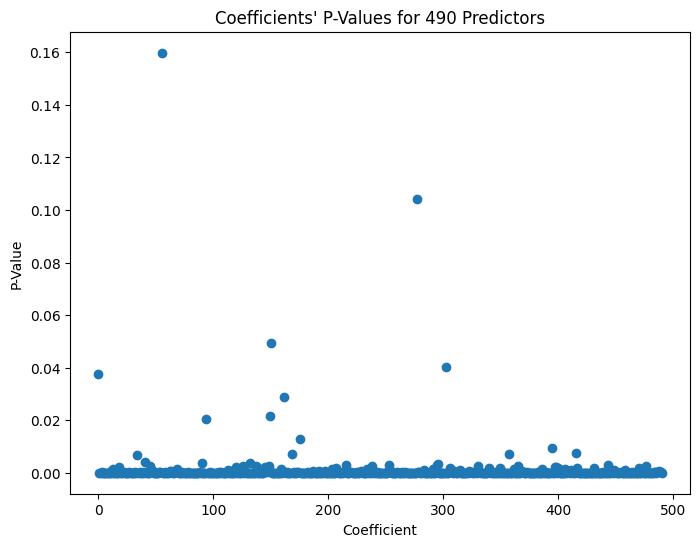

In [24]:
import statsmodels.api as sm

m490 = sm.OLS(Y[:,488], sm.add_constant(X.iloc[:,:490])).fit()
plt.plot(np.arange(491), m490.pvalues, 'o')
plt.title("Coefficients' P-Values for 490 Predictors")
plt.xlabel("Coefficient")
plt.ylabel("P-Value");

In [25]:
m2 = sm.OLS(Y[:,0], sm.add_constant(X.iloc[:,:2])).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.409e+04
Date:                Sun, 25 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:08:01   Log-Likelihood:                -701.44
No. Observations:                 500   AIC:                             1409.
Df Residuals:                     497   BIC:                             1422.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0097      0.044     22.824      0.0

Both summaries show pretty strong significance of all predictors and good fits.    
But check 95% confidence intervals for the first predictor $X_{i,1}$ estimated by both models.    


In [26]:
print(tuple(m2.conf_int().loc['X1']))

(2.6438141751731714, 2.73396739544634)


In [29]:
print(tuple(m490.conf_int().loc['X1']))

(2.323327755780268, 3.2994819855223043)


**Explain the difference.**    

Plot $R^2$ returned by all nested models.    


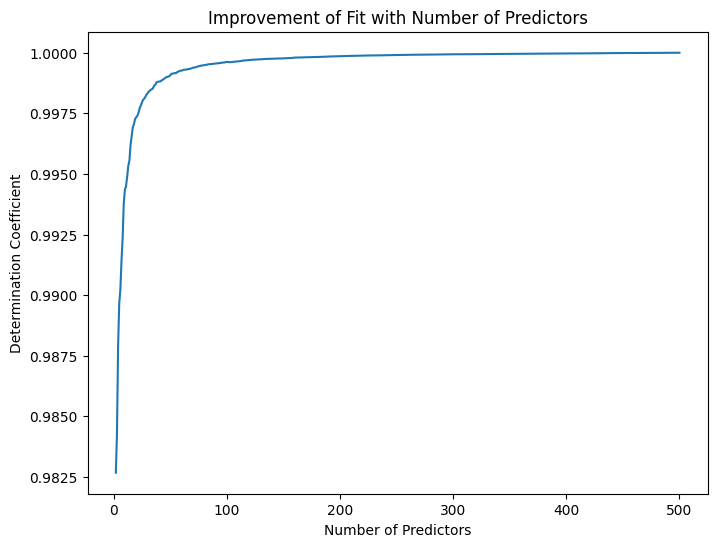

In [30]:
fits = [sm.OLS(Y[:,j-2], sm.add_constant(X.iloc[:,:j])).fit() for j in range(2, 501)]

rSquared = [fit.rsquared for fit in fits] 
plt.plot(range(2, 501), rSquared)
plt.title("Improvement of Fit with Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Determination Coefficient");

Plot adjusted $R^2$ returned by all nested models.

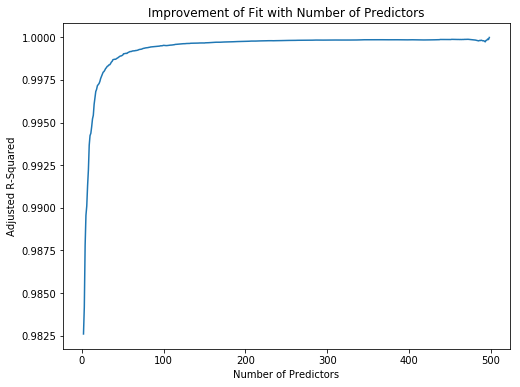

In [14]:
adjustedRSquared = [fit.rsquared_adj for fit in fits]
plt.plot(range(2, 501), adjustedRSquared)
plt.title("Improvement of Fit with Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Adjusted R-Squared");

Plot confidence intervals returned by all nested models.

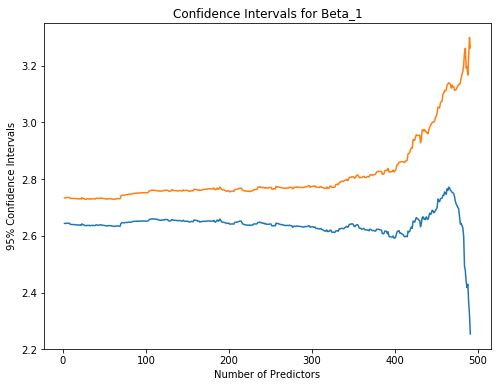

In [15]:
leftConfInt = [fit.conf_int().iloc[1,0] for fit in fits]
rightConfInt = [fit.conf_int().iloc[1,1] for fit in fits]
plt.plot(range(2, 492), leftConfInt[:490])
plt.plot(range(2, 492), rightConfInt[:490])
plt.title("Confidence Intervals for Beta_1")
plt.xlabel("Number of Predictors")
plt.ylabel("95% Confidence Intervals");

Alternatively, you can do the same analysis with a "large model" that is simulated using 500 predictors.    
Add predictors one by one and plot $R^2$ and confidence intervals for $\beta_1$.    


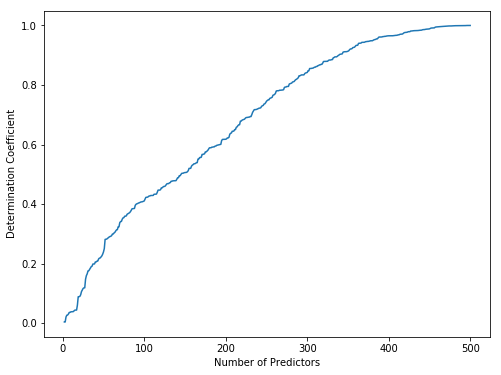

In [16]:
fits500 = [sm.OLS(Y[:,500-2], sm.add_constant(X.iloc[:,:j])).fit() for j in range(2, 501)]

rSquared500 = [fit.rsquared for fit in fits500]
plt.plot(range(2, 501), rSquared500)
plt.xlabel("Number of Predictors")
plt.ylabel("Determination Coefficient");

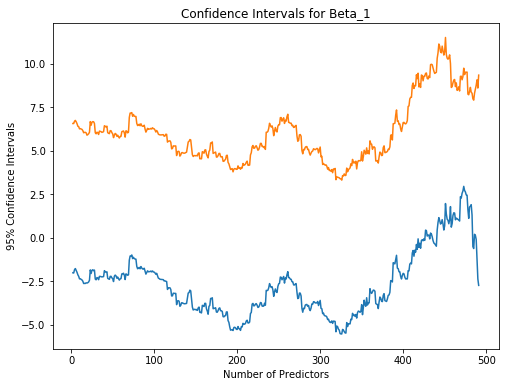

In [17]:
leftConfInt500 = np.array([fit.conf_int().iloc[1,0] for fit in fits500])
rightConfInt500 = np.array([fit.conf_int().iloc[1,1] for fit in fits500])
plt.plot(range(2, 492), leftConfInt500[:490])
plt.plot(range(2, 492), rightConfInt500[:490])
plt.title("Confidence Intervals for Beta_1")
plt.xlabel("Number of Predictors")
plt.ylabel("95% Confidence Intervals");

Confidence interval in this case is so wide that it is not easy to see its dynamics.    
Plot absolute value of its width.   

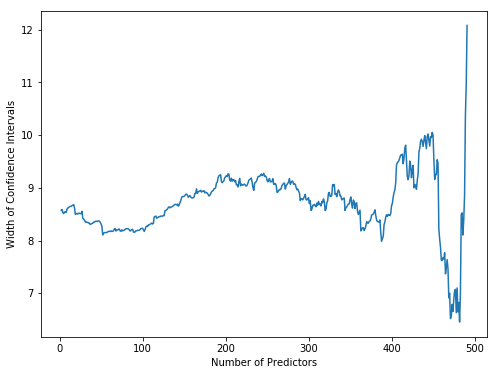

In [18]:
plt.plot(range(2, 492), rightConfInt500[:490] - leftConfInt500[:490])
plt.xlabel("Number of Predictors")
plt.ylabel("Width of Confidence Intervals");

**Conclusions:**    
1. As number of predictors grows the quality of fit expressed as $R^2$ or adjusted $R^2$ continuously improves.    
2. But inference for a fixed predictor becomes less and less accurate, which is shown by the widening confidence interval.     
3. This means that if there is, for example, one significant predictor $X_{i,1}$, by increasing the total number of predictors (even though they all or many of them may be significant) we can damage accuracy of estimation of the slope for $X_{i,1}$.     
4. This example shows one problem that DM has to face, which is not emphasized in traditional courses on statistical analysis where only low numbers of predictors are considered.

## Selecting predictors for regression problem    

### Method based on `drop1()`    

Probably, the main method recommended in textbooks is based on `drop1()` which selects next excluded variable based on `AIC`.      
Apply this method to a typical textbook model dimension, for example, use 10 predictors.

In [31]:
m10 = sm.OLS(Y[:,8], sm.add_constant(X.iloc[:,:10])).fit()
print(m10.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     8606.
Date:                Sun, 25 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:36:24   Log-Likelihood:                -699.40
No. Observations:                 500   AIC:                             1421.
Df Residuals:                     489   BIC:                             1467.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0127      0.045     22.645      0.0

In [32]:
def drop1(X,y):
    names = X.columns
    res = pd.DataFrame(index=['RSS','AIC','R-squared'], columns = names)
    lm0 = sm.OLS(y,sm.add_constant(X)).fit()
    res['<None>'] = [lm0.ssr, lm0.aic, lm0.rsquared]
    for c in names:
        lm = sm.OLS(y,sm.add_constant(X[names.drop(c)])).fit()
        res[c] = [lm.ssr, lm.aic, lm.rsquared]
    return res.T.dropna()

drop1_m10 = drop1(X.iloc[:,:10], Y[:,8])
print(drop1_m10)

                 RSS          AIC  R-squared
X1      13460.223133  3085.381574   0.841642
X2      11668.177650  3013.944762   0.862725
X3       3886.087576  2464.213567   0.954280
X4      11541.326634  3008.479231   0.864217
X5       8272.485165  2841.979607   0.902675
X6       4010.234748  2479.937014   0.952820
X7       7267.964966  2777.250289   0.914493
X8       5831.119502  2667.116627   0.931397
X9      14457.705007  3121.125869   0.829906
X10      8741.184610  2869.534983   0.897161
<None>    480.262625  1420.801029   0.994350


In [33]:
bestToDrop = drop1_m10.loc[drop1_m10['AIC'].idxmin()]
print(bestToDrop)

RSS           480.262625
AIC          1420.801029
R-squared       0.994350
Name: <None>, dtype: float64


The decision recommended by the method is not to exclude any predictors.    
This is not surprising: all predictors were used to simulate the model with betas different from zero.    

### Relative importance measures   

Calculate relative importance measures of the model predictors.     


In [36]:
def rel_imp_me(X, y): 
    names = X.columns
    ser = pd.Series(index = names)
    lm0 = sm.OLS(y, sm.add_constant(X)).fit()
    for c in names:
        lm = sm.OLS(y, sm.add_constant(X[names.drop(c)])).fit()
        ser[c] = lm0.rsquared - lm.rsquared 
    res = pd.DataFrame(columns =['last', 'first', 'betasq', 'pratt'], index=names)
    res['last'] = ser
    corr = X.apply(lambda x: np.corrcoef(y,x)[0,1], axis=0)
    res['first'] = corr**2
    sx = X.apply(np.std, axis=0)
    res['betasq'] = (lm0.params[names] * sx / np.std(y))**2
    res['pratt'] = (lm0.params[names] * sx / np.std(y)) * corr
    return res

metrics10 = rel_imp_me(X.iloc[:,:10], Y[:,8])
metrics10

,last,first,betasq,pratt
X1,0.152708,0.251994,0.158449,0.199820
X2,0.131625,0.102708,0.137370,0.118781
X3,0.040069,0.015938,0.040711,0.025472
X4,0.130133,0.085837,0.132500,0.106646
X5,0.091675,0.118474,0.093204,0.105082
X6,0.041530,0.026044,0.042928,0.033437
X7,0.079857,0.101476,0.080784,0.090541
X8,0.062952,0.067679,0.064610,0.066127
X9,0.164444,0.133458,0.175859,0.153199
X10,0.097189,0.090575,0.100155,0.095245


Compare sums of several measures with the $R^2$ of the model with 10 predictors.   

In [37]:
print(metrics10.sum())
print('\nR2 =', m10.rsquared)

last      0.992182
first     0.994182
betasq    1.026570
pratt     0.994350
dtype: float64

R2 = 0.9943497472271303


The goal of each measure is to decompose the total $R^2$ into contributions by different predictors.    

Each measure ranks predictors in the order of their relative importance.   

In [38]:
metrics10_first_rank = metrics10["first"].rank(ascending=False, method='first')
print(metrics10_first_rank)

X1      1.0
X2      4.0
X3     10.0
X4      7.0
X5      3.0
X6      9.0
X7      5.0
X8      8.0
X9      2.0
X10     6.0
Name: first, dtype: float64


In [39]:
metrics10_sort = pd.DataFrame({"Predictors" : metrics10_first_rank.index,
  "Slopes" : slopesSet[:10],
  "Rank" : metrics10_first_rank.values}).sort_values(by="Rank") 
print(metrics10_sort[["Predictors","Slopes"]])

  Predictors    Slopes
0         X1  2.676982
8         X9  2.811744
4         X5  1.982844
1         X2  2.389029
6         X7  1.816513
9        X10  2.190996
3         X4  2.665900
7         X8  1.726208
5         X6  1.384162
2         X3  1.285500


Ranks correspond to the order of the coefficients used in simulation: the larger the coefficient, the higher the rank.     
This is expected: all predictors were simulated as independent samples from the same distribution and mixed with weights equal to the coefficients.     

Compare growth of the determination coefficient in cases of original order of predictors and the improved order.  

In [40]:
orderedPredictors = pd.DataFrame(X, columns=metrics10_sort["Predictors"])
orderedPredictors.shape

(500, 10)

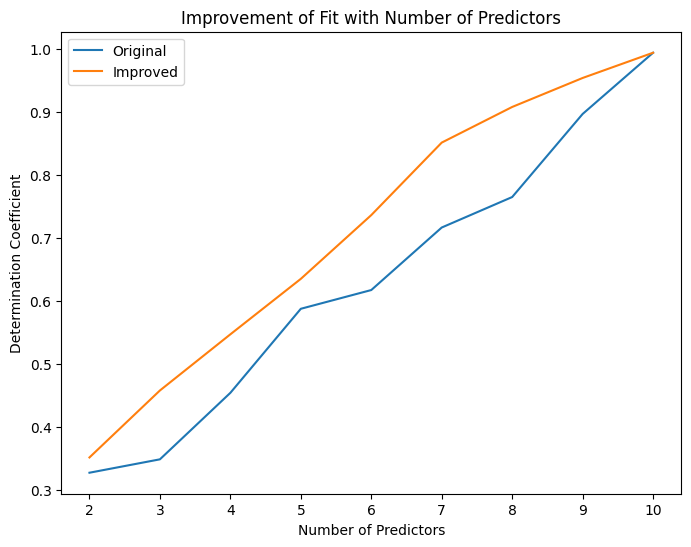

In [41]:
def rSquar(j, y, X) :
    return sm.OLS(y, sm.add_constant(X.iloc[:,:j])).fit().rsquared

originalR2_10 = [rSquar(j,Y[:,8],X) for j in range(2, 11)]
improvedR2_10 = [rSquar(j,Y[:,8],orderedPredictors) for j in range(2, 11)]

plt.plot(range(2, 11), originalR2_10, label="Original")
plt.plot(range(2, 11), improvedR2_10, label="Improved")
plt.title("Improvement of Fit with Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Determination Coefficient")
plt.legend();

Note that both trajectories have to give the same result when number of predictors is 10.    
But using the improved order high levels of $R^2$ can be achieved much earlier, meaning with fewer predictors.   
The chart can be used to decide how many predictors in the improved order is necessary to achieve the desired level of $R^2$.   

### Regsubsets    

In [42]:
def regsubsets(X,y): 
    names = X.columns
    first = X.apply(lambda x: np.corrcoef(y,x)[0,1] ** 2, axis=0)
    names0 = [first.idxmax()]
    rsq = [first.max()]
    print(0, names0)
    for i in range(names.size-1):
        ser = pd.Series(index=names)
        for s in names.drop(names0):
            lm = sm.OLS(y, sm.add_constant(X[names0 + [s]])).fit()
            ser[s] = lm.rsquared
        names0.append(ser.idxmax())
        rsq.append(ser.max())
        print(i+1, names0)
    return rsq

subsets_rsq = regsubsets(X.iloc[:,:10], Y[:,8]) 

0 ['X1']
1 ['X1', 'X5']
2 ['X1', 'X5', 'X4']
3 ['X1', 'X5', 'X4', 'X9']
4 ['X1', 'X5', 'X4', 'X9', 'X2']
5 ['X1', 'X5', 'X4', 'X9', 'X2', 'X10']
6 ['X1', 'X5', 'X4', 'X9', 'X2', 'X10', 'X7']
7 ['X1', 'X5', 'X4', 'X9', 'X2', 'X10', 'X7', 'X8']
8 ['X1', 'X5', 'X4', 'X9', 'X2', 'X10', 'X7', 'X8', 'X6']
9 ['X1', 'X5', 'X4', 'X9', 'X2', 'X10', 'X7', 'X8', 'X6', 'X3']


Relative importance of predictors can be obtained from the last line above.

Compare the selected order with `metrics10_first_rank`.

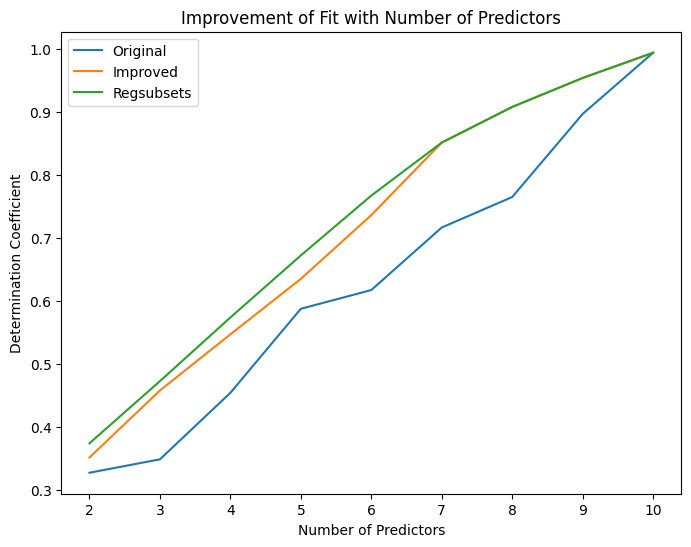

In [43]:
plt.plot(range(2, 11), originalR2_10, label="Original")
plt.plot(range(2, 11), improvedR2_10, label="Improved")
plt.plot(range(2, 11), subsets_rsq[1:], label="Regsubsets")

plt.title("Improvement of Fit with Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Determination Coefficient")
plt.legend();

## Adding more predictors

Previous section is a review of predictors selection in a traditional statistical analysis course, plus the method `regsubsets()` recommended in the book.        
In order to understand the the problems that need to be solved in modern data mining do the following:    

* If necessary, rearrange calculations into a script or a function that takes the simulated data and runs predictors selection for a given set of predictors using the following methods:  `first`, `last` and `resubsets()`.    
For example, for 50 predictors use the output `Y[:,48]` and predictors `X.iloc[:,:50]`.     
* Run each method with increasing number of predictors and create a report with the largest number of predictors you are able to obtain.   
For example, add 10 predictors at a time.    
If you are able to run the problem with 490 or so predictors then the method is suitable for solving a machine learning problem in R.    

Which of the methods covered so far you prefer?     

**Recommendations:**     
Turn off all unnecessary applications on your computer, save all unsaved files.    
Be prepared for a frustrating experience. You may be pushing your hardware to a limit.    
Good luck.  